In [18]:
import os
import glob
import numpy as np
import pandas as pd
import joblib

from sklearn.preprocessing import MultiLabelBinarizer, StandardScaler
from sklearn.model_selection import train_test_split
from xgboost import XGBClassifier

import matplotlib.pyplot as plt

In [36]:
def binning(bin_var, bin_min, bin_max, n_bin):
    bin_xs = np.concatenate(([-np.inf], np.linspace(bin_min, bin_max, n_bin + 1), [np.inf]), axis=0)
    bin_step = bin_xs[2] - bin_xs[1]
    bin_centers = []
    for i in range(1, len(bin_xs) - 2):
        bin_centers.append((bin_xs[i] + bin_xs[i+1]) / 2)
    bin_centers = np.concatenate(([bin_centers[0] - bin_step], bin_centers, [bin_centers[-1] + bin_step]), axis=0)
    
    bin_indices = np.digitize(bin_var, bin_xs) - 1
    bin_masks = [(bin_indices == i) for i in range(len(bin_xs) - 1)]
    return bin_xs, bin_centers, bin_masks

In [20]:
data_dir = '/users/hep/eigen1907/STORE/TrackDetMatches'
detid_table_path = '/users/hep/eigen1907/Workspace/Workspace-DL/241222-det_raw_id/matched_det_raw_id.csv'
input_model_dir = '/users/hep/eigen1907/Workspace/Workspace-DL/241222-XGBoost/model/file300-e100-d5-lr0.1'

model = XGBClassifier()
model.load_model(os.path.join(input_model_dir, 'model.json'))
track_scaler = joblib.load(os.path.join(input_model_dir, 'scaler.pkl'))
detid_encoder = joblib.load(os.path.join(input_model_dir, 'encoder.pkl'))

eval_paths = sorted(glob.glob(os.path.join(data_dir, '*.csv')))[-100:]
df_list = [pd.read_csv(eval_path) for eval_path in eval_paths]
df = pd.concat(df_list, ignore_index=True)
df['det_raw_id'] = df['det_raw_id'].apply(lambda x: list(map(int, x.split(' ')[:-1])))

X = track_scaler.transform(df[['track_pt', 'track_eta', 'track_phi']].values)
Y = detid_encoder.transform(df['det_raw_id'])

In [38]:
Y_pred_proba = model.predict_proba(X)
prob_cut = 0.1
Y_pred = (Y_pred_proba > prob_cut).astype(int)

track_pt = df['track_pt'].values
track_eta = df['track_eta'].values
track_phi = df['track_phi'].values

n_diff = (Y != Y_pred).sum(axis=1)
n_only_data = (Y > Y_pred).sum(axis=1)
n_only_pred = (Y < Y_pred).sum(axis=1)

print(track_pt)
print(track_eta)
print(track_phi)

print(n_diff)
print(n_only_data)
print(n_only_pred)

print('-'*100)
print(f'TrackDetMatches Max: {(Y != 0).sum(axis=1).max()}, Min: {(Y != 0).sum(axis=1).min()}')

print('-'*100)
print(f'predict probability > {prob_cut}')
print(f'diff data, pred: {(Y_pred != Y).sum(axis=1).mean():.2f}')
print(f'only data      : {(Y_pred < Y).sum(axis=1).mean():.2f}')
print(f'only pred      : {(Y_pred > Y).sum(axis=1).mean():.2f}')

[ 638.158 1332.59   719.929 ...  753.56   883.535 1179.86 ]
[-2.37227   2.37189  -0.109127 ... -0.892338 -1.36581   1.36623 ]
[ 2.53343  -0.607991 -0.70089  ...  1.0804    1.53053  -1.61091 ]
[0 1 5 ... 0 1 0]
[0 0 0 ... 0 0 0]
[0 1 5 ... 0 1 0]
----------------------------------------------------------------------------------------------------
TrackDetMatches Max: 25, Min: 1
----------------------------------------------------------------------------------------------------
predict probability > 0.1
diff data, pred: 2.16
only data      : 0.14
only pred      : 2.02


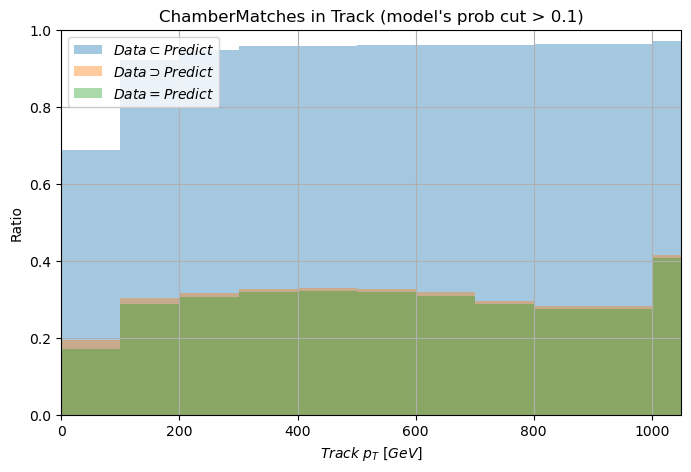

In [43]:
bin_xs, bin_centers, bin_masks = binning(track_pt, 0, 1000, 10)
no_diff_ratio, data_in_pred_ratio, pred_in_data_ratio = [], [], []

for bin_mask in bin_masks:
    unique, count = np.unique(n_diff[bin_mask], return_counts=True)
    no_diff_ratio.append(count[0] / count.sum() if len(count) != 0 else 0)

    unique, count = np.unique(n_only_pred[bin_mask], return_counts=True)
    pred_in_data_ratio.append(count[0] / count.sum() if len(count) != 0 else 0)

    unique, count = np.unique(n_only_data[bin_mask], return_counts=True)
    data_in_pred_ratio.append(count[0] / count.sum() if len(count) != 0 else 0)


plt.figure(figsize=(8, 5))

plt.bar(bin_centers, data_in_pred_ratio, width=100, alpha=0.4, label=r'$Data \subset Predict$')
plt.bar(bin_centers, pred_in_data_ratio, width=100, alpha=0.4, label=r'$Data \supset Predict$')
plt.bar(bin_centers, no_diff_ratio, width=100, alpha=0.4, label=r'$Data = Predict$')

plt.xlim(0, bin_centers[-1])
plt.ylim(0, 1.0)

plt.xlabel(r'$Track\ p_{T}\ [GeV]$')
plt.ylabel('Ratio')
plt.title(f'ChamberMatches in Track (model\'s prob cut > {prob_cut})')

plt.legend()
plt.grid(True)
plt.show()

/tmp/ipykernel_1828483/869384102.py:7: RuntimeWarning: Mean of empty slice.
  mean_n_only_data.append(n_only_data[bin_mask].mean())
/users/hep/eigen1907/micromamba/envs/torch-cpu/lib/python3.10/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/tmp/ipykernel_1828483/869384102.py:8: RuntimeWarning: Mean of empty slice.
  mean_n_only_pred.append(n_only_pred[bin_mask].mean())


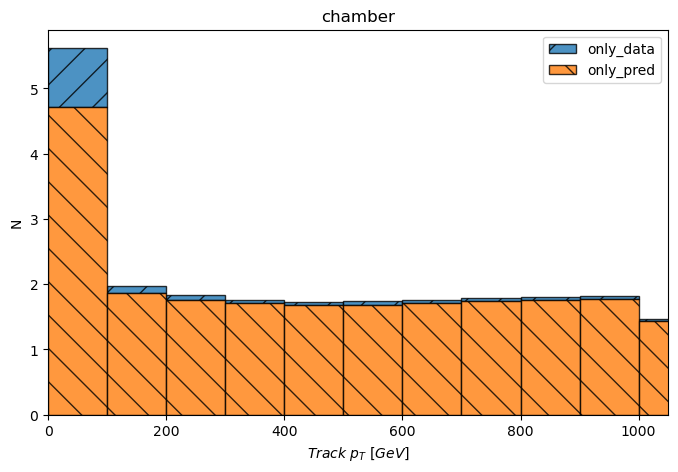

In [ ]:
bin_xs, bin_centers, bin_masks = binning(track_pt, 0, 1000, 10)

mean_n_only_data = []
mean_n_only_pred = []

for bin_mask in bin_masks:
    mean_n_only_data.append(n_only_data[bin_mask].mean())
    mean_n_only_pred.append(n_only_pred[bin_mask].mean())

plt.figure(figsize=(8, 5))

plt.bar(
    bin_centers,
    mean_n_only_data,
    bottom=mean_n_only_pred,
    width=100,
    label='only_data',
    edgecolor='black',
    linewidth=1.0,
    hatch='/',
    alpha=0.8 
)
plt.bar(
    bin_centers,
    mean_n_only_pred,
    width=100,
    label='only_pred',
    edgecolor='black',
    linewidth=1.0,
    hatch='\\',
    alpha=0.8
)

plt.xlim(0, bin_centers[-1])

plt.xlabel(r'$Track\ p_{T}\ [GeV]$')
plt.ylabel('N')
plt.title(f'chamber')

plt.legend()
#plt.grid(True)
plt.show()

/tmp/ipykernel_1828483/4218597952.py:7: RuntimeWarning: Mean of empty slice.
  mean_n_only_data.append(n_only_data[bin_mask].mean())
/users/hep/eigen1907/micromamba/envs/torch-cpu/lib/python3.10/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/tmp/ipykernel_1828483/4218597952.py:8: RuntimeWarning: Mean of empty slice.
  mean_n_only_pred.append(n_only_pred[bin_mask].mean())


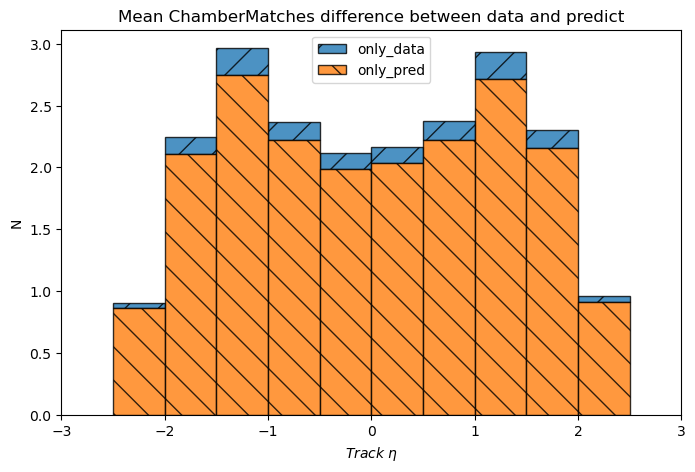

In [ ]:
bin_xs, bin_centers, bin_masks = binning(track_eta, -2.5, 2.5, 10)

mean_n_only_data = []
mean_n_only_pred = []

for bin_mask in bin_masks:
    mean_n_only_data.append(n_only_data[bin_mask].mean())
    mean_n_only_pred.append(n_only_pred[bin_mask].mean())

plt.figure(figsize=(8, 5))
plt.bar(
    bin_centers,
    mean_n_only_data,
    bottom=mean_n_only_pred,
    width=0.5,
    label='only_data',
    edgecolor='black',
    linewidth=1.0,
    hatch='/',
    alpha=0.8

)
plt.bar(
    bin_centers,
    mean_n_only_pred,
    width=0.5,
    label='only_pred',
    edgecolor='black',
    linewidth=1.0,
    hatch='\\',
    alpha=0.8
)

plt.xlim(-3.0, 3.0)
#plt.ylim(0, 1.0)

plt.xlabel(r'$Track\ \eta$')
plt.ylabel('N')
plt.title(f'Mean ChamberMatches difference between data and predict')

plt.legend()
#plt.grid(True)
plt.show()

/tmp/ipykernel_1828483/3358855484.py:7: RuntimeWarning: Mean of empty slice.
  mean_n_only_data.append(n_only_data[bin_mask].mean())
/tmp/ipykernel_1828483/3358855484.py:8: RuntimeWarning: Mean of empty slice.
  mean_n_only_pred.append(n_only_pred[bin_mask].mean())


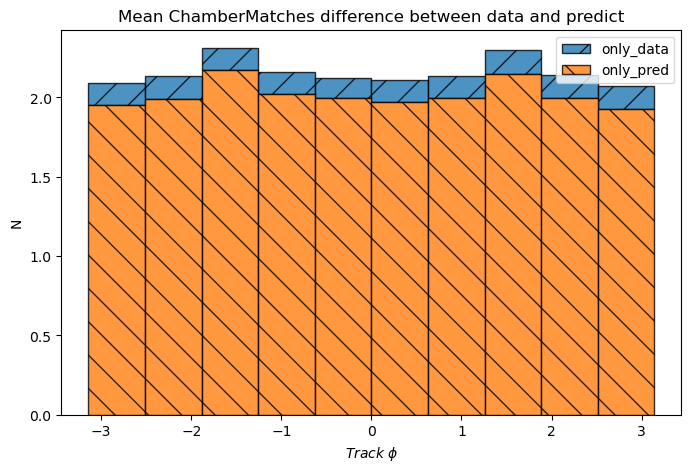

In [68]:
bin_xs, bin_centers, bin_masks = binning(track_phi, -np.pi, np.pi, 10)

mean_n_only_data = []
mean_n_only_pred = []

for bin_mask in bin_masks:
    mean_n_only_data.append(n_only_data[bin_mask].mean())
    mean_n_only_pred.append(n_only_pred[bin_mask].mean())

plt.figure(figsize=(8, 5))
plt.bar(
    bin_centers,
    mean_n_only_data,
    bottom=mean_n_only_pred,
    width=0.2*np.pi,
    label='only_data',
    edgecolor='black',
    linewidth=1.0,
    hatch='/',
    alpha=0.8,
)
plt.bar(
    bin_centers,
    mean_n_only_pred,
    width=0.2*np.pi,
    label='only_pred',
    edgecolor='black',
    linewidth=1.0,
    hatch='\\',
    alpha=0.8 
)

plt.xlim(-np.pi - 0.3, np.pi + 0.3)

plt.xlabel(r'$Track\ \phi$')
plt.ylabel('N')
plt.title(f'Mean ChamberMatches difference between data and predict')

plt.legend()
#plt.grid(True)
plt.show()